In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.signal

In [77]:

def read_csv_to_arrays(filename):
    time_values = []
    amplitude_values = []

    # Open the CSV file and read line by line
    with open(filename, 'r') as file:
        # Skip metadata lines
        for _ in range(9):
            next(file)

        # Read the CSV data
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                try:
                    time_val = float(parts[0])
                    ampl_val = float(parts[1])
                    time_values.append(time_val)
                    amplitude_values.append(ampl_val)
                except ValueError:
                    continue

    # Convert lists to NumPy arrays
    time_values = np.array(time_values, dtype=np.float32)
    amplitude_values = np.array(amplitude_values, dtype=np.float32)

    return time_values, amplitude_values

def read_multiple_csv_to_arrays(pattern):
    # Get a list of filenames using glob
    filenames = glob.glob(pattern)

    # Initialize lists to store time and amplitude arrays
    all_time_arrays = []
    all_amplitude_arrays = []

    # Iterate through the filenames and read data from each file
    for filename in filenames:
        time_values, amplitude_values = read_csv_to_arrays(filename)
        all_time_arrays.append(time_values)
        all_amplitude_arrays.append(amplitude_values)

    return all_time_arrays, all_amplitude_arrays




def fit_gaussian_noise(amplitude_values, max_amplitude=0.02):
    # Plot the histogram of amplitude values
    plt.figure(figsize=(10, 6))
    # Calculate the histogram without plotting it
    hist, bin_edges, _ = plt.hist(amplitude_values[amplitude_values <= max_amplitude], bins=50, density=True, alpha=0.6, color='b', label='Histogram')

    # Get bin width and calculate the area under the histogram
    bin_width = bin_edges[1] - bin_edges[0]
    area_under_hist = np.sum(hist * bin_width)

    # Fit a Gaussian (normal) distribution to the data
    mu, sigma = norm.fit(amplitude_values[amplitude_values <= max_amplitude])

    # Generate x values for the Gaussian curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)

    # Plot the Gaussian fit normalized to the histogram area
    p = norm.pdf(x, mu, sigma) * area_under_hist
    plt.plot(x, p, 'k', linewidth=2, label='Gaussian fit')

    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.legend()

    # Print the Gaussian parameters
    print('Mu (mean):', mu)
    print('Sigma (standard deviation):', sigma)

    plt.show()
    return mu, sigma



In [78]:
# Example usage
pattern = r'C:\Users\Garrett\Desktop\SiPM_Dark_Waveforms\*.csv'  # Adjust the pattern to match your files
time_arrays, amplitude_arrays = read_multiple_csv_to_arrays(pattern)
time_arrays=np.array(time_arrays)
amplitude_arrays=np.array(amplitude_arrays)

Mu (mean): 0.0031325452
Sigma (standard deviation): 0.0025028884


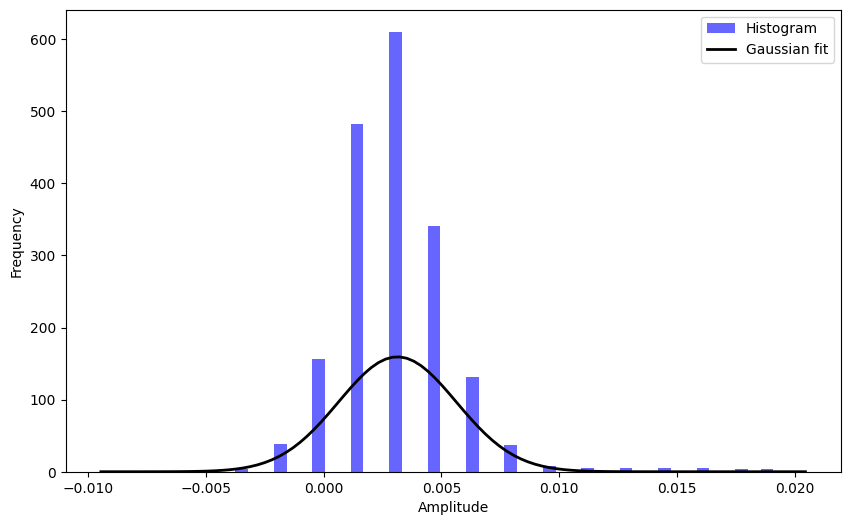

Removing baseline


In [79]:

mu_baseline, sigma_baseline = fit_gaussian_noise(np.concatenate(amplitude_arrays))
print('Removing baseline')
amplitude_arrays=amplitude_arrays-mu_baseline

In [80]:
def find_pulses(time_values, amplitude_values, pulse_threshold=0.03, pulse_width=5):
    # Smooth the waveform to make peak detection more accurate
    # Find peaks in the smoothed waveform
    smoothed_amplitude = scipy.signal.savgol_filter(amplitude_values, window_length=17, polyorder=3)
    peaks, _ = scipy.signal.find_peaks(smoothed_amplitude, height=pulse_threshold, distance=10)
    
    return peaks

Detected pulse peaks: [ 1140  2083  4502  5592  8423  8582 10097 11642 11947 13338 15188 20402
 20544 21759 22580 22708 23453 27378 28971 31589 32121 35249 35319 37106
 39593 40168 41345 42453 42862 43090 44946 47251 50052 50336 50452 51055
 53362 53389 53880 57176 58556 59066 59379 69496 71031 71675 71952 72132
 73899 75046 75128 75193 75369 78234 80089 80313 81791 87089 87936 91151
 91256 92921 96050 97694 97941 98505 99686]


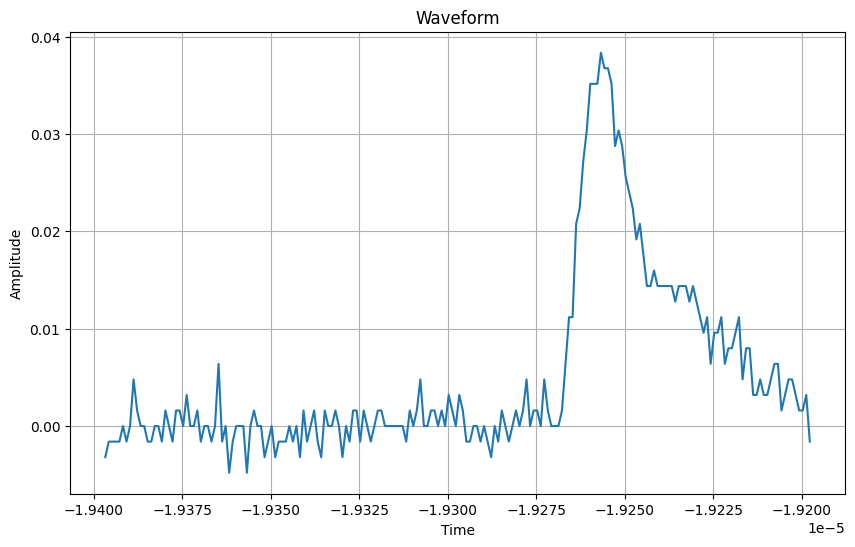

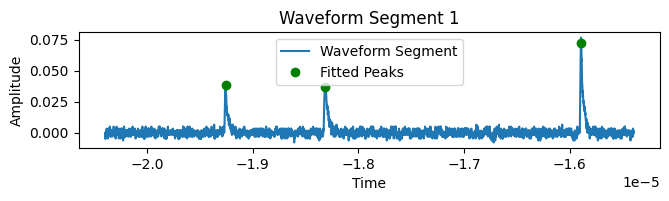

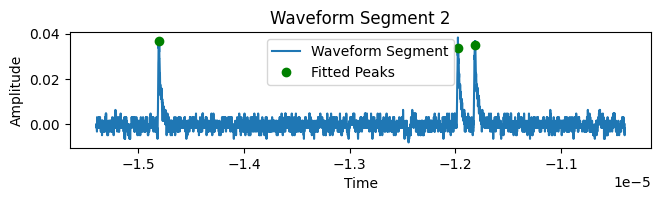

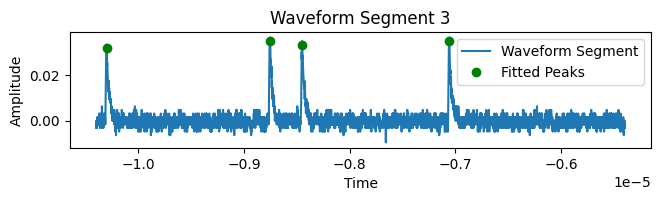

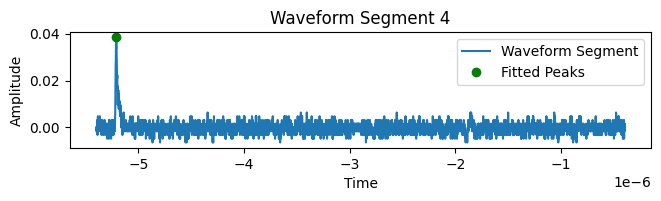

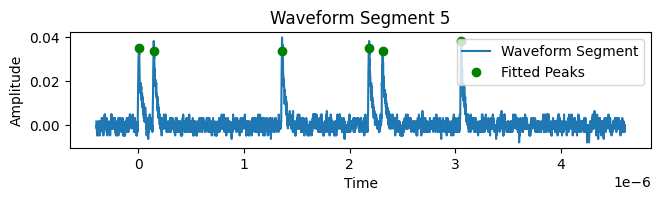

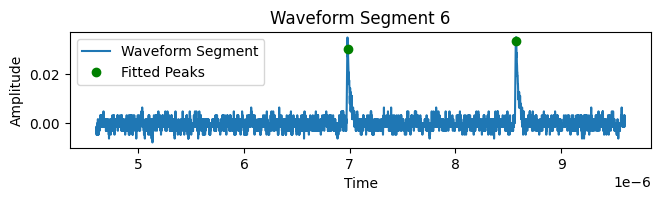

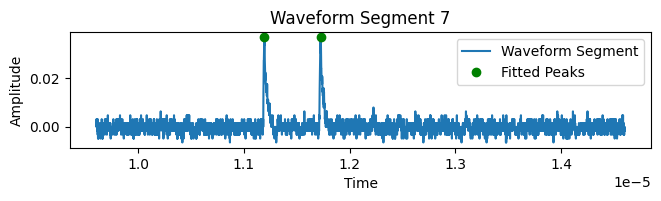

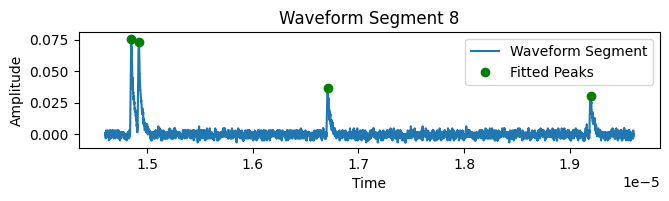

In [91]:


def plot_waveforms(time_values, amplitude_values):
    plt.figure(figsize=(10, 6))
    plt.plot(time_values, amplitude_values)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.grid(True)
    plt.show()


def plot_waveform_segments(time_values, amplitude_values, fitted_peaks=None, segment_size=5000):
    num_segments = len(amplitude_values) // segment_size
    remainder = len(amplitude_values) % segment_size

    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        
        # Plot the waveform segment
        plt.figure(figsize=(7.5, 1.5))
        plt.plot(time_values[start_idx:end_idx], amplitude_values[start_idx:end_idx], label='Waveform Segment')
        
        # Plot the fitted peaks for this segment
        if fitted_peaks is not None:
            segment_fitted_peaks = [peak for peak in fitted_peaks if start_idx <= peak < end_idx]
            plt.plot(time_values[segment_fitted_peaks], amplitude_values[segment_fitted_peaks], 'go', label='Fitted Peaks')
        
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title(f'Waveform Segment {i+1}')
        plt.legend()
        plt.show()

    # Plot the remainder segment
    if remainder > 0:
        start_idx = num_segments * segment_size
        plt.figure(figsize=(7.5, 1.5))
        plt.plot(time_values[start_idx:], amplitude_values[start_idx:], label='Waveform Segment (Remainder)')
        
        # Plot the fitted peaks for the remainder segment
        if fitted_peaks is not None:
            segment_fitted_peaks = [peak for peak in fitted_peaks if start_idx <= peak]
            plt.plot(time_values[segment_fitted_peaks], amplitude_values[segment_fitted_peaks], 'go', label='Fitted Peaks')
        
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('Waveform Segment (Remainder)')
        plt.legend()
        plt.show()

peaks = find_pulses(time_arrays[0], amplitude_arrays[0])
print("Detected pulse peaks:", peaks)


# Plot the waveforms for the first file
plot_waveforms(time_arrays[0][1000:1200], amplitude_arrays[0][1000:1200])

for i in range(1):
    
    # Suppose you have an array of fitted peak indices called fitted_peaks
    fitted_peaks = np.array(find_pulses(time_arrays[0], amplitude_arrays[0]))
    # Plot the waveform in segments with fitted peaks
    plot_waveform_segments(time_arrays[0][0:40000], amplitude_arrays[0][0:40000], fitted_peaks=fitted_peaks)

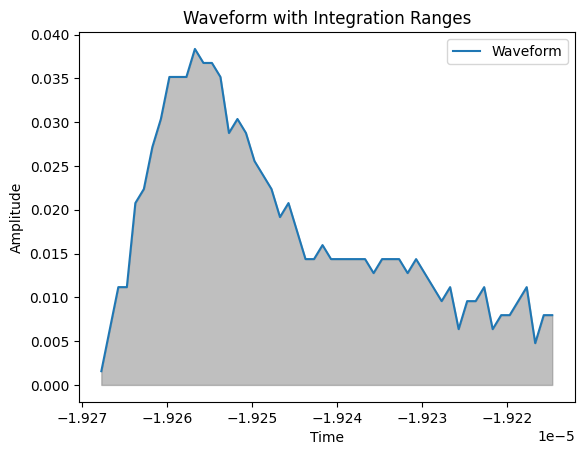

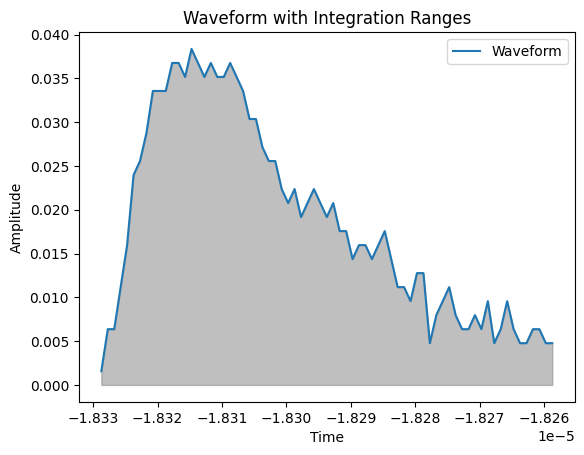

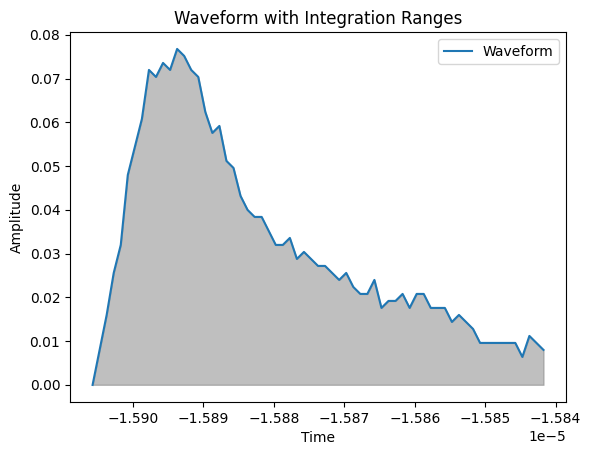

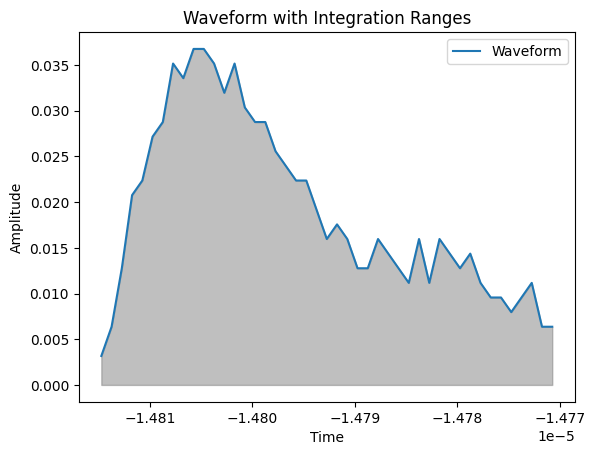

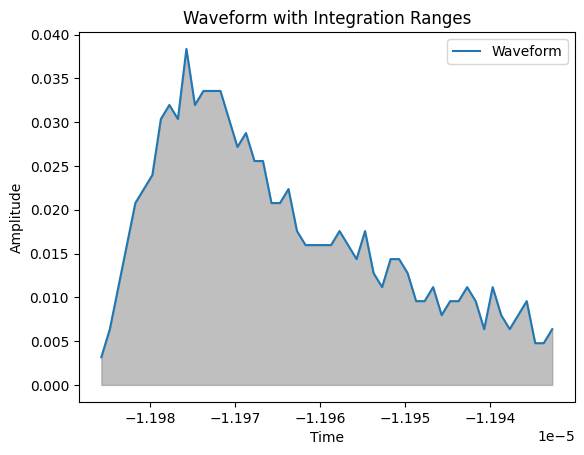

Total area under pulses: [9.406294e-10, 1.3144711e-09, 2.0386293e-09, 8.4813717e-10, 9.198346e-10]


In [82]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_area_under_pulses(amplitudes, times, pulse_peaks, threshold=0.009, plot=False):
    total_area = []

    for peak_index in pulse_peaks:
        # Check if the pulse amplitude exceeds the threshold
        if amplitudes[peak_index] >= threshold:
            # Find the start and end indices for the pulse
            start_index = peak_index
            end_index = peak_index

            # Move back in time to find the start of the pulse
            while start_index > 0 and amplitudes[start_index] >= threshold:
                start_index -= 1

            # Move forward in time to find the end of the pulse
            while end_index < len(times) - 1 and amplitudes[end_index] >= threshold:
                end_index += 1

            # Calculate the area under the pulse (integral)
            pulse_area = np.trapz(amplitudes[start_index:end_index], x=times[start_index:end_index])
            total_area.append(pulse_area)

            # Plot the curve and the integration range
            if plot:
                plt.plot(times[start_index:end_index], amplitudes[start_index:end_index], label='Waveform')
                plt.fill_between(times[start_index:end_index], amplitudes[start_index:end_index], color='gray', alpha=0.5)

        if plot:
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.title('Waveform with Integration Ranges')
            plt.show()

    return total_area

# Example usage

# Threshold for pulse detection
threshold = 0.004

# Calculate the area under pulses that pass the threshold and plot the curves
total_pulse_area = calculate_area_under_pulses(amplitude_arrays[0], time_arrays[0], peaks[0:5], threshold, plot=True)
print("Total area under pulses:", total_pulse_area)


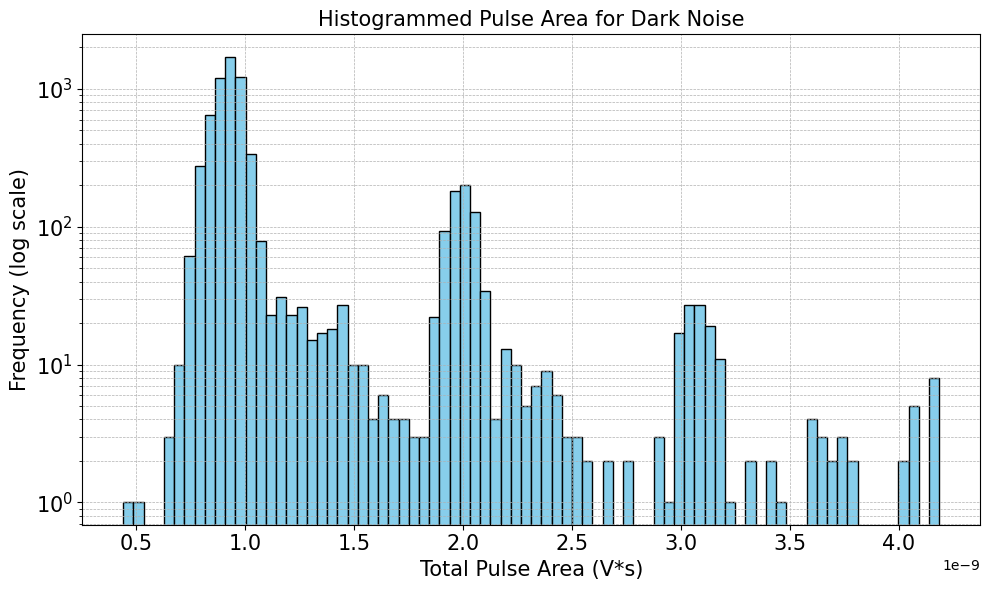

dark rate 630495 Hz


In [88]:
all_waveforms=np.concatenate(amplitude_arrays)
all_times=np.concatenate(time_arrays)
threshold = 0.005
peaks=find_pulses(all_times,all_waveforms)
total_pulse_area = calculate_area_under_pulses(all_waveforms, all_times, peaks, threshold, plot=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(total_pulse_area, bins=80, color='skyblue', edgecolor='black')
plt.yscale('log')

plt.xlabel('Total Pulse Area (V*s)', fontsize=15)
plt.ylabel('Frequency (log scale)', fontsize=15)
plt.title('Histogrammed Pulse Area for Dark Noise', fontsize=15)
plt.xticks(fontsize=15)  # Change font size of x-axis ticks
plt.yticks(fontsize=15)  # Change font size of y-axis ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


total_time=np.sum(time_arrays[:,-1]-time_arrays[:,0])
#print the total darkrate

print('dark rate', int(len(peaks)/total_time), 'Hz')

In [9]:
total_time=time_arrays[:][-1]-time_arrays[:][0]
print(np.sum(time_arrays[:,-1]-time_arrays[:,0]))

print(time_arrays[:,-1])

0.010499685
[7.9600271e-05 7.9600395e-05 7.9600562e-05 7.9600548e-05 7.9600315e-05
 7.9600657e-05 7.9600628e-05 7.9600664e-05 7.9600009e-05 7.9600279e-05
 7.9600599e-05 7.9600744e-05 7.9600322e-05 7.9600395e-05 7.9600060e-05
 7.9600119e-05 7.9600672e-05 7.9600170e-05 7.9600373e-05 7.9600519e-05
 7.9600817e-05 7.9600293e-05 7.9600461e-05 7.9600788e-05 7.9600672e-05
 7.9600053e-05 7.9600330e-05 7.9600642e-05 7.9600133e-05 7.9600279e-05
 7.9600199e-05 7.9600373e-05 7.9600402e-05 7.9600650e-05 7.9600046e-05
 7.9600184e-05 7.9600461e-05 7.9600220e-05 7.9600126e-05 7.9600737e-05
 7.9600861e-05 7.9600752e-05 7.9600744e-05 7.9600417e-05 7.9600039e-05
 7.9600795e-05 7.9600730e-05 7.9600308e-05 7.9600286e-05 7.9600817e-05
 7.9600795e-05 7.9600330e-05 7.9600926e-05 7.9600417e-05 7.9600562e-05
 7.9600773e-05 7.9600388e-05 7.9600621e-05 7.9600570e-05 7.9600904e-05
 7.9600642e-05 7.9600293e-05 7.9600853e-05 7.9600817e-05 7.9600846e-05
 7.9600497e-05 7.9600824e-05 7.9600395e-05 7.9600526e-05 7.960090

In [12]:

pattern = r'D:\New Folder\*_34ns*.csv'  # Adjust the pattern to match your files
time_arrays, amplitude_arrays = read_multiple_csv_to_arrays(pattern)
time_arrays=np.array(time_arrays)
amplitude_arrays=np.array(amplitude_arrays)

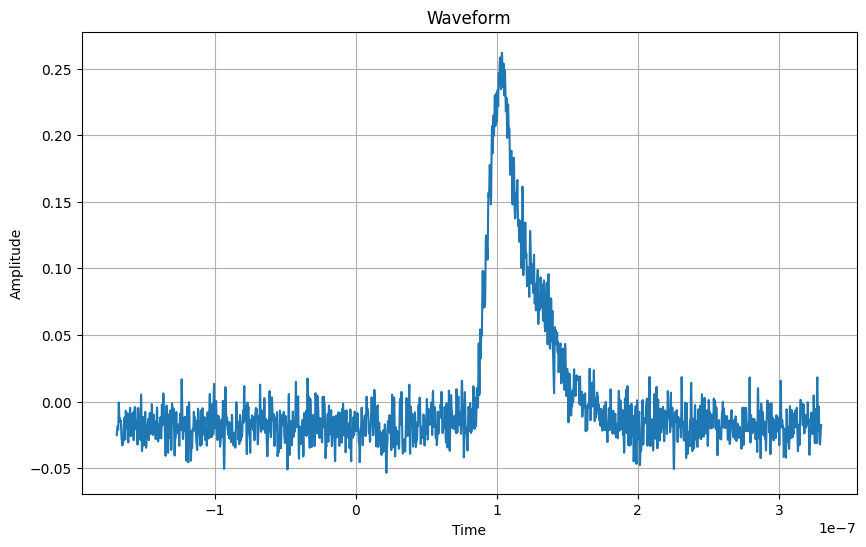

In [16]:
plot_waveforms(time_arrays[0],amplitude_arrays[0])
fitted_peaks=find_pulses(np.concatenate(time_arrays), np.concatenate(amplitude_arrays))

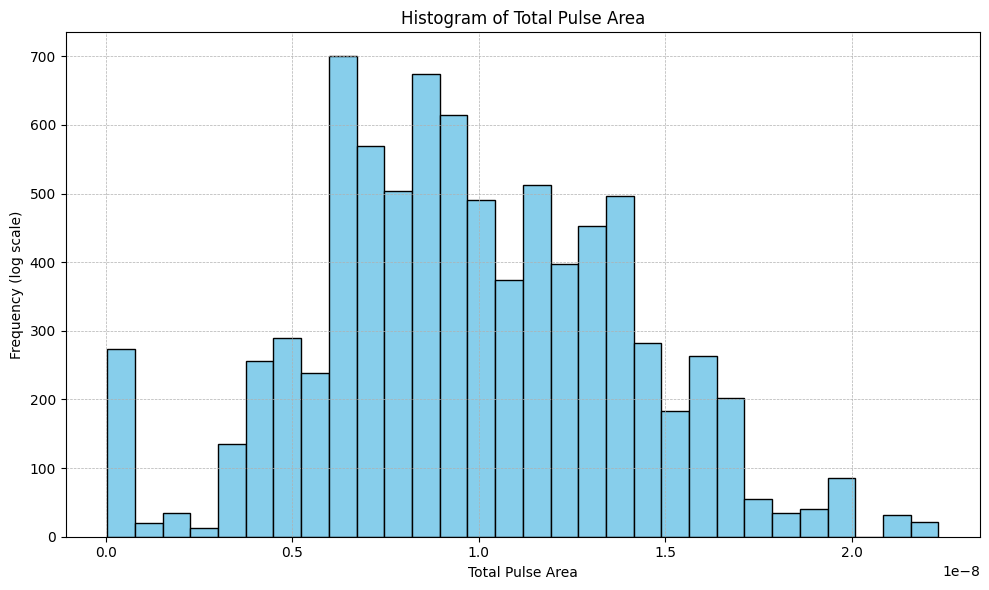

dark rate 35675645 Hz


In [20]:
all_waveforms=np.concatenate(amplitude_arrays)
all_times=np.concatenate(time_arrays)
threshold = 0.005
peaks=find_pulses(all_times,all_waveforms)
total_pulse_area = calculate_area_under_pulses(all_waveforms, all_times, peaks, threshold, plot=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(total_pulse_area, bins=30, color='skyblue', edgecolor='black')
plt.yscale('linear')

plt.xlabel('Total Pulse Area')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Total Pulse Area')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


total_time=np.sum(time_arrays[:,-1]-time_arrays[:,0])
#print the total darkrate

#print('dark rate', int(len(peaks)/total_time), 'Hz')

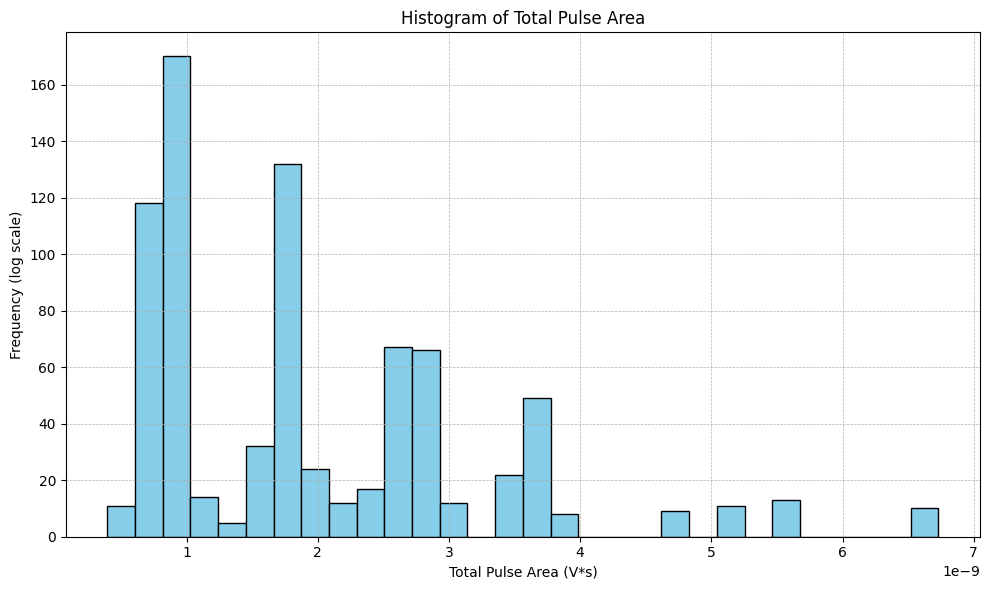

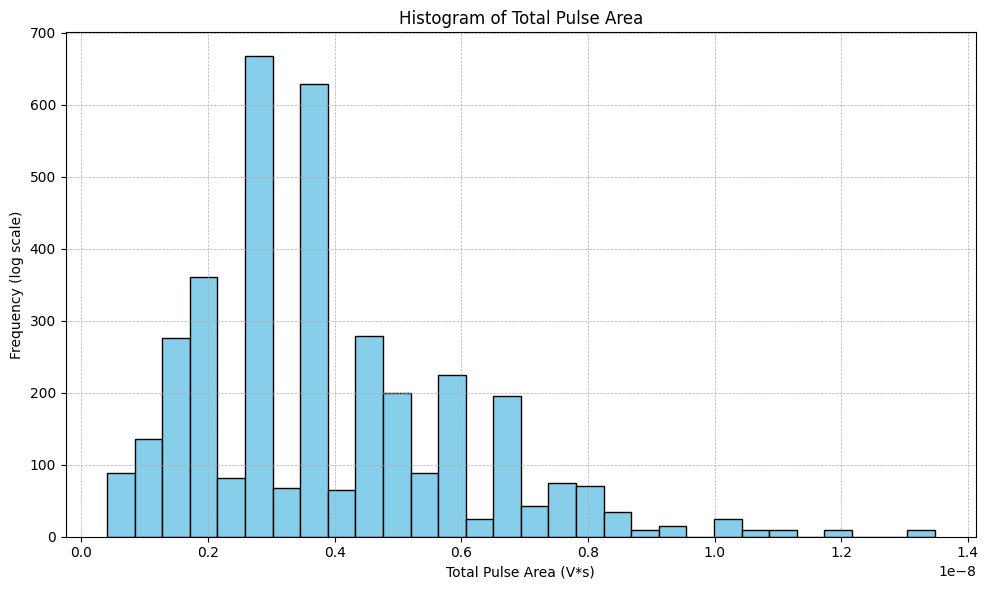

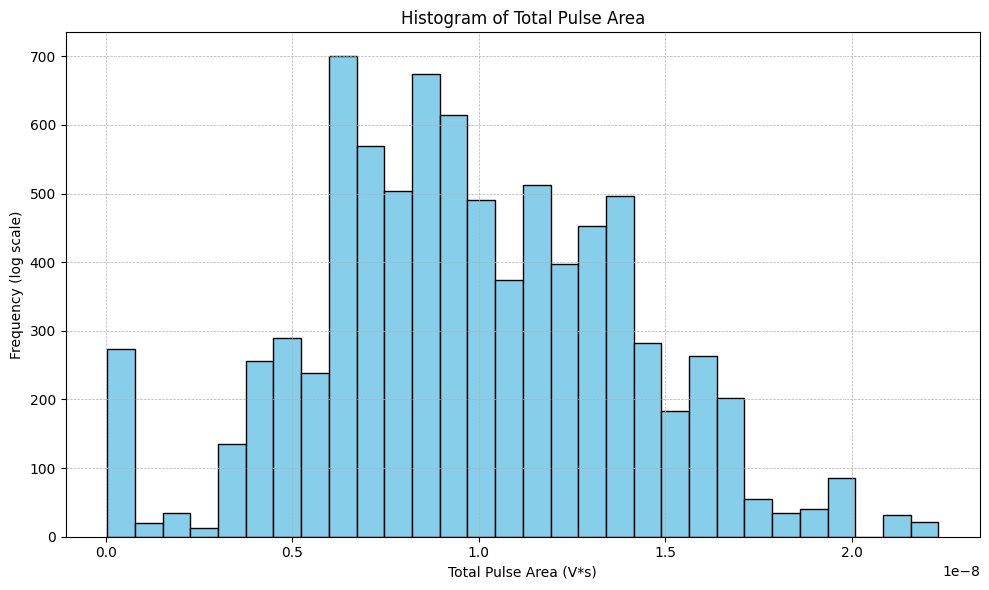

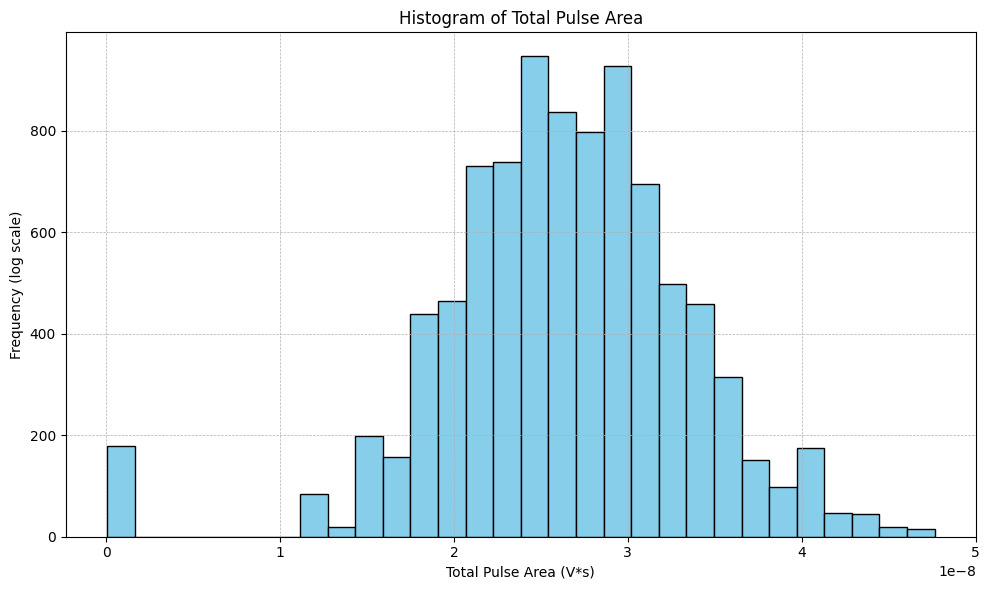

In [75]:
avgs=[]

for ns in range(32,36):
    pattern = r'D:\New Folder\*_'+str(ns)+'ns*.csv'  # Adjust the pattern to match your files
    time_arrays, amplitude_arrays = read_multiple_csv_to_arrays(pattern)
    time_arrays=np.array(time_arrays)
    amplitude_arrays=np.array(amplitude_arrays)
    
    all_waveforms=np.concatenate(amplitude_arrays)
    all_times=np.concatenate(time_arrays)
    threshold = 0.005
    peaks=find_pulses(all_times,all_waveforms)
    total_pulse_area = calculate_area_under_pulses(all_waveforms, all_times, peaks, threshold)
    avgs.append(np.average(total_pulse_area))
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(total_pulse_area, bins=30, color='skyblue', edgecolor='black',density=False)
    plt.yscale('linear')
    
    plt.xlabel('Total Pulse Area (V*s)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Histogram of Total Pulse Area')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    


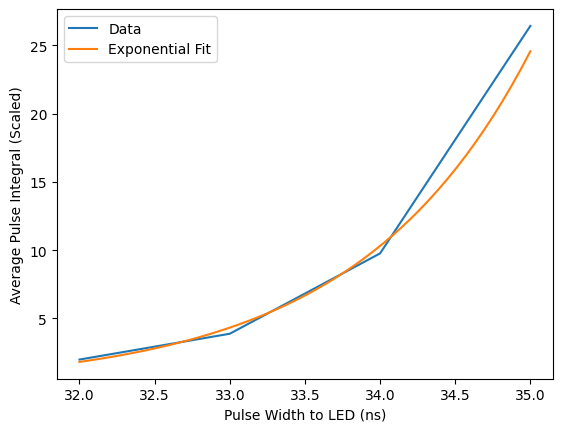

In [64]:
xaxis=np.array([ns for ns in range(32,36)])
plt.plot(xaxis,np.array(avgs)/1e-9, label="Data")
plt.plot(np.linspace(32,35,50),0.761*np.exp(0.8686*(np.linspace(1,4,50))),label='Exponential Fit')
plt.xlabel("Pulse Width to LED (ns)")
plt.ylabel("Average Pulse Integral (Scaled)")
plt.legend()
plt.show()

In [54]:
print(np.array(avgs)/1e-9)

[ 1.9864119  3.877637   9.759528  26.4184   ]
